In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import namedtuple

In [2]:
#the jig is a half-line. It extends infinitely in one direction
#the state includes the displacement (signed distance) from the object to the jig

#   |---> (positive displacement)
#   o   jjjjjj...
# -------->  (coordinate frame attached to object)

# in 1D, you can't rotate the object, so the object frame positive x axis always points to the left
# whether you're plotting in world frame or object frame
#       <---| (negative displacement)
# ..jjjj   o
#  --------> (coordinate frame attached to object)

# HOWEVER, if we attach a coordinate frame to the jig, such 0 is the boundary, 
# and the negative direction is occupied by jig, then in this coordinate frame, 
# the displacment to the object is always positive
# BUT now we need to encode whether the object frame points left or right,
# since that's the frame you can specify the actions in.
# (I think this is actually less obvious in 1D than in higher dimensions)

# To make the case analogous with the x, y, \theta case consider the following state space

$\left( \mathbf{R}_{+} \times \mathbf{\theta} \right) \cup \mathbf{C}$

$\theta$ in the 1D case takes on one of two values. $\mathbf{C}$ is binary-valued and says whether you're in contact or not. In this 1D case, there is only one contact manifold, and it's zero dimensional.

One departure from the 2D case is that you can't really transition from one $\theta$ value to the other. However, it's still necessary to include it in the state, because in a ($\theta=0^\circ$) world, taking a step in the positive direction increases the displacement from the jig. In a ($\theta=180^\circ$) world, taking a a step in the positive direction *decreases* the displacement.

For comparison, the plannar domain we're considering has the following state space:

$\left( \mathbf{R}_{+} \times \mathbf{R}_{+} \times \mathbf{\theta} \right) 
\cup \left( \mathbf{R}_{+} \times \mathbf{\theta} \right)
\cup \left( \mathbf{R}_{+} \times \mathbf{\theta} \right)
\cup \left( \mathbf{\theta} \right)
\cup \mathbf{C}$

(I'm being informal in writing $\theta$. It really is $SO(2)$)

The space correspond, in order, to:
- the no-contact manifold
- contact with one arm of the jig
- contact with the other arm of the jig
- contact with both arms of the jig
- and the questionably the double-edge contact with the square object is in the corner of the jig

The non-negativity on the real coordinates are applicable when you take the state to be the pose of the object expressed in the jig frame. If you take the pose of the jig expressed in the object frame, then you can't say the coordinates are non-negative

Actually, let us use this state space
$\left( \mathbf{R}_{+} \cup \mathbf{C} \right)\times \mathbf{\theta}$

When we are up against the contact, which of the following is true?
- moving in the positive direction will further push into the contact
- moving in the positive direction will break contact

$\theta$ tells us.

In [3]:
# I am crazy to do this. But this prevents rogue types from being generated (like DirectionStateFactor(3.2))
# And also allows these to be used as dict keys (they are immutable)

#What it doesn't let me do is make a type hierarchy that well.

DirectionStateFactorBase = namedtuple("DirectionStateFactor", ["d"])
class DirectionStateFactor(DirectionStateFactorBase):
    def __new__(cls, d):    
        if d == 1:
            _d = 1
        elif d == -1:
            _d = -1
        else:
            raise ValueError("direction: %s"%d)

        self = super(DirectionStateFactor, cls).__new__(cls, d)
        return self

    def __repr__(self):
        return "Direction: %s"%(self.d)

DisplacementStateFactor = namedtuple("DisplacementStateFactor", []) #"abstract" type

MetricStateFactorBase = namedtuple("MetricStateFactor", ["x"])
class MetricStateFactor(MetricStateFactorBase):
    def __new__(cls, x):
        assert(x%1 == 0) #it's an index into some discretization
        self = super(MetricStateFactor, cls).__new__(cls, x)
        return self

    def __repr__(self):
        return "Metric: %s"%(self.x)

class VoidStateFactor(DisplacementStateFactor):
    def __new__(cls):
        self = super(VoidStateFactor, cls).__new__(cls)
        return self

    def __eq__(self, other):
        return self.__class__ == other.__class__
    
    def __repr__(self):
        return "Void"

class ContactStateFactor(DisplacementStateFactor):
    def __new__(cls):
        self = super(ContactStateFactor, cls).__new__(cls)
        return self

    def __eq__(self, other):
        return self.__class__ == other.__class__
    
    def __repr__(self):
        return "Contact"

#I don't want them to inherit the equality method. and I was the hashing to be unique.
assert( not (ContactStateFactor() == VoidStateFactor() ) )

StateBase = namedtuple("State", ["direction", "displacement"])
    
class State(StateBase):
    def __new__(cls, direction_factor, displacement_factor):
        assert(isinstance(direction_factor, DirectionStateFactor))
        assert(isinstance(displacement_factor, MetricStateFactor) or #this line would have been avoided if I figured out subclassing
              isinstance(displacement_factor, DisplacementStateFactor))
        self = super(State, cls).__new__(cls, direction_factor, displacement_factor)
        return self

    def __repr__(self):
        return "State: " + ("+" if self.direction.d==1 else "-") + self.displacement.__repr__()

class StateSpace(object):
    def __init__(self, extent=5.0, n_resolution=51):
        self.extent = extent
        self.n_resolution = n_resolution
        self.discretization_free = np.linspace(0, self.extent, self.n_resolution)
        self.n_directions = 2
        
        self.others_displacement = [ContactStateFactor, VoidStateFactor]
        self.n_states = (len(self.discretization_free) + len(self.others_displacement))*self.n_directions
            
    def to_continuous(self, state, frame="jig"):
        assert isinstance(state.displacement, MetricStateFactor)
        if frame=="jig":
            return (self.discretization_free[state.displacement.x], state.direction.d)
        elif frame=="object":
            print("confirm this, tho")
            return (-state.direction.d * self.discretization_free[state.displacement.x], -state.direction.d)

    def nearest(self, xd, frame="jig"):
        x, d = xd # displacement and direction
        if frame != "jig":
            raise NotImplementedError()

        if x >= self.extent:
            return State(DirectionStateFactor(d), VoidStateFactor())
        elif x<0:
            raise NotImplementedError() #This might actually just need to be an error
        else:
            i = np.searchsorted(self.discretization_free, x)
            if i == 0:
                return State(DirectionStateFactor(d), MetricStateFactor(0))
            else:
                if abs(self.discretization_free[i-1]-x) < abs(self.discretization_free[i]-x):
                    return State(DirectionStateFactor(d), MetricStateFactor(i-1))
                else:
                    return State(DirectionStateFactor(d), MetricStateFactor(i))

    def interpolate(self, xd, frame="jig"):
        x, d = xd # displacement and direction
        if frame != "jig":
            raise NotImplementedError()

        # return affine combination of states
        # interpolating x when x is outside the extent puts all of the mass in the void.
        if x >= self.extent:
            return [(1.0, State(DirectionStateFactor(d), VoidStateFactor()) )]
        elif x<0:
            raise NotImplementedError() #This might actually just need to be an error
        else:
            i = np.searchsorted(self.discretization_free, x)
            if i == 0:
                raise AssertionError("previous checks should have caught: %s"%(x))
            else:
                a = x - self.discretization_free[i-1]
                b = self.discretization_free[i] - x
                if a<0 or b<0:
                    raise AssertionError("negative distance: %s"%((a,b)))
                
                return [ (b/(a+b), State(DirectionStateFactor(d), MetricStateFactor(i-1))),
                         (a/(a+b), State(DirectionStateFactor(d), MetricStateFactor(i))) ]

# once this runs, you have to recreate it. make it behave like an iterator again one day
def state_generator(state_space):
        for d in [DirectionStateFactor(-1), DirectionStateFactor(+1)]:
            yield State(d, ContactStateFactor())
            yield State(d, VoidStateFactor())
            for i in range(len(state_space.discretization_free)):
                yield State(d, MetricStateFactor(i))
        

In [4]:
state_space = StateSpace()
state_space.to_continuous(state_space.nearest((2.14, +1)))

(2.1000000000000001, 1)

In [5]:
state_space.nearest((0.1, +1))

State: +Metric: 1

In [6]:
state_space.interpolate((2.65, -1))

[(0.50000000000000222, State: -Metric: 26),
 (0.49999999999999778, State: -Metric: 27)]

In [7]:
list(state_generator(state_space))[0:6]

[State: -Contact,
 State: -Void,
 State: -Metric: 0,
 State: -Metric: 1,
 State: -Metric: 2,
 State: -Metric: 3]

In [8]:
class Belief(object):
    def __init__(self, state_space=state_space, delta=None):
        self.state_space = state_space
        
        self.p = {}
        self.directions = [DirectionStateFactor(-1), DirectionStateFactor(1)]
        self.displacements = [ContactStateFactor(), VoidStateFactor(), 'free_metric']

        for d in self.directions:
            self.p[d] = {ContactStateFactor():0.0,
                        VoidStateFactor():0.0,
                        'free_metric':np.zeros_like(self.state_space.discretization_free)}
        
        
        if delta is not None:
            if isinstance(delta, State):
                if isinstance(delta.displacement, MetricStateFactor):
                    self.p[delta.direction]['free_metric'][delta.displacement.x] = 1.0
                elif isinstance(delta.displacement, DisplacementStateFactor):
                    self.p[delta.direction][delta.displacement] = 1.0
                else:
                    raise ValueError(delta)
            else:
                raise ValueError(delta)
    
    def prob(self, state):
        if isinstance(state, State):
            if isinstance(state.displacement, MetricStateFactor):
                return self.p[state.direction]['free_metric'][state.displacement.x]
            elif isinstance(state.displacement, DisplacementStateFactor):
                return self.p[state.direction][state.displacement]
            else:
                raise ValueError(state)
        else:
            raise ValueError(state)
    
    @staticmethod
    def blend(affine_combo):
        coeffs = np.array([a for (a, b) in affine_combo])
        
        if not np.isclose(np.sum(coeffs), 1.0) or not np.all(coeffs>=0.0):
            raise ValueError("invalid combination: %s"%(coeffs))
        
        #assume each belief is normalized
        blended = Belief()

        for (a,b) in affine_combo:
            assert(np.isclose(b.sum(),1.0))
            for d in blended.directions:
                for m in blended.displacements:
                    blended.p[d][m] += a*b.p[d][m]

        if not np.isclose(blended.sum(), 1.0):
            raise AssertionError("sum should have come out to 1.0: %s"%(blended.sum()))
        
        return blended
            
    def something(self):
        for d in self.directions:
            self.p[d][ContactStateFactor()] = np.random.rand()
            self.p[d][VoidStateFactor()] = np.random.rand()
            self.p[d]['free_metric'] = 0.1 * np.random.rand(len(self.state_space.discretization_free))
    
        self.normalize()

    def sum(self):
        s = 0.0
        for d in self.directions:
            s += self.p[d][ContactStateFactor()]
            s += self.p[d][VoidStateFactor()]
            s += np.sum(self.p[d]['free_metric'])
        return s
       
    def normalize(self):
        eta = 1.0/(self.sum())

        for d in self.directions:
            self.p[d][ContactStateFactor()] *= eta
            self.p[d][VoidStateFactor()] *= eta
            self.p[d]['free_metric'] *= eta


    def plot(self, ax, frame="object", p_metric_kwargs=dict(color='grey',linestyle="")):
        belief = self
    
        artists=[]

        def plot_single_stem(ax, x, y, 
                             marker_kwargs=dict(markersize=5.0, alpha=1.0, color='darkblue'), 
                             stemline_kwargs=dict(linewidth=4.0, alpha=0.5, color='dimgrey')):
            a = [] #store artists
            a.extend(
                ax.plot([x, x], [0.0, y], **stemline_kwargs))
            
       
            a.extend(
                ax.plot([x], [y], marker='s', **marker_kwargs))
            return a
        
        for d in self.directions:
            _d = d.d
            artists.extend(
                plot_single_stem(ax, -_d*0.05, 
                                 belief.p[d][ContactStateFactor()]) )
            artists.extend(
                plot_single_stem(ax, -_d*belief.state_space.extent, 
                                 belief.p[d][VoidStateFactor()]) )
            
            artists.extend(
                ax.plot(_d*belief.state_space.discretization_free, 
                            belief.p[d]['free_metric'], 
                            marker=".", **p_metric_kwargs) )
        return artists

    def metric_mean(self):
        # The graphical notion of a mean only really makes sense in the object frame
        
        s = self.p[DirectionStateFactor(1)]['free_metric'].sum() + self.p[DirectionStateFactor(-1)]['free_metric'].sum()
        if s == 0:
            raise ValueError("Metric manifold has zero probability")
        if s>1:
            raise ValueError("Metric manifold had %s>1 probability"%(s))
        return ( np.dot(self.p[DirectionStateFactor(-1)]['free_metric']/s, -self.state_space.discretization_free)+
                 np.dot(self.p[DirectionStateFactor(+1)]['free_metric']/s, self.state_space.discretization_free) )

    
    def metric_variance(self):
        m = self.metric_mean()
        s = self.p[DirectionStateFactor(1)]['free_metric'].sum() + self.p[DirectionStateFactor(-1)]['free_metric'].sum()
        return ( np.dot(self.p[DirectionStateFactor(-1)]['free_metric']/s, (-self.state_space.discretization_free-m)**2)+
                 np.dot(self.p[DirectionStateFactor(+1)]['free_metric']/s, (self.state_space.discretization_free-m)**2) )

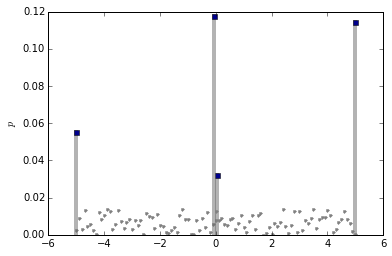

In [9]:
def setup_belief_plot(ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.axhline(0.0)
    ax.set_ylabel(r"$p$")
    return ax

ax = setup_belief_plot()
b = Belief()
b.something()
b.plot(ax);

In [10]:
b.metric_mean()

0.0047142386648026946

In [11]:
def ideally_identity(xd):
    # interpolate a continuous point onto the metric part
    # convert to a distribution over the metric states (a Belief)
    # take the mean of the belief
    affine_combo = state_space.interpolate(xd)
    affine_combo = [(a,Belief(delta=b)) for (a,b) in affine_combo]
    return Belief.blend(affine_combo).metric_mean()

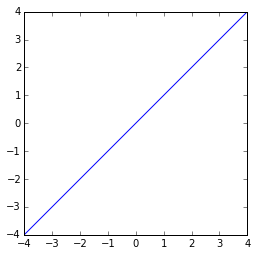

In [12]:
#a sort of unit test. the line should be straight with slope=1
x = np.linspace(-4,4,10000)
y = map(ideally_identity, [(abs(d), 1 if d>0 else -1) for d in x])
plt.plot(x,y)
plt.gca().set_aspect(1.0)

In [13]:
#another sort of unit test
etas = [Belief(delta=s).sum() for s in state_generator(state_space)]

if not np.all([np.isclose(eta, 1.0) for eta in etas]):
    print("Test Fail")

    for s in state_generator(state_space):
        if not np.isclose(Belief(delta=s).sum(), 1.0):
            print(s)

In [14]:
b = Belief(delta=State( DirectionStateFactor(1), ContactStateFactor()))

for s in state_generator(state_space):
    if b.prob(s) != 0:
        print(s, b.prob(s))

(State: +Contact, 1.0)


In [15]:
b = Belief()
b.p[DirectionStateFactor(1)][ContactStateFactor()] = 1

In [16]:
for s in state_generator(state_space):
    if b.prob(s) != 0:
        print(s, b.prob(s))

(State: +Contact, 1)


In [17]:
class Action(object):
    pass


class GuardedVelocity(Action):
    def __init__(self, velocity):
        self.velocity = velocity
        #self.time_left = 1.0
        #self.finished = False

    def propogate_belief(self, belief, dt=0.1):
        to_blend = []
        for state in state_generator(state_space):
            a = belief.prob(state)
            b = self.propogate_state(state, dt)
            to_blend.append( (a, b) )
        
        return Belief.blend(to_blend)

    def propogate_state(self, state, dt=0.1):     
        if isinstance(state.displacement, MetricStateFactor):
            x = state_space.to_continuous(state)[0]
            xprime = x + dt*self.velocity*state.direction.d
            
            if xprime >= 0:
                affine_combo = state_space.interpolate((xprime, state.direction.d))
                affine_combo = [(a,Belief(delta=b)) for (a,b) in affine_combo]
                b = Belief.blend(affine_combo)
            else:
                # made contact
                # TODO this would activate a guard, probably. and the termination condition would be set
                b = Belief(delta=State(state.direction, ContactStateFactor()))

        elif isinstance(state.displacement, ContactStateFactor):
            contact_direction = state.direction.d
            if contact_direction * self.velocity >= 0:
                #pushing into contact, so stay with same contact
                b = Belief(delta=state)
            else:
                #moving away from contact. with probability alpha, stay in contact
                alpha = 0.1
                
                xprime = 0.0 + dt*self.velocity*contact_direction
                affine_combo = state_space.interpolate((xprime, state.direction.d))
                affine_combo = [(a,Belief(delta=b)) for (a,b) in affine_combo]
                b_metric = Belief.blend(affine_combo)
                b_contact = Belief(delta=state)
                
                b = Belief.blend([  (alpha, b_contact),
                                    (1-alpha, b_metric)])

        elif isinstance(state.displacement, VoidStateFactor):
            void_direction = -state.direction.d
            if void_direction * self.velocity >= 0:
                #going further into void, so stay in same void
                b = Belief(delta=state)
            else:
                #moving toward metric. with probability alpha, stay in the void
                alpha = 0.9
                
                void_fringe = state_space.extent * void_direction
                xprime = void_fringe + dt*self.velocity*state.direction.d
                affine_combo = state_space.interpolate((xprime, state.direction.d))
                affine_combo = [(a,Belief(delta=b)) for (a,b) in affine_combo]
                b_metric = Belief.blend(affine_combo)
                b_void = Belief(delta=state)
                
                b = Belief.blend([  (alpha, b_void),
                                    (1-alpha, b_metric)])

        return b
        
        

class Position(Action):
    def __init__(self):
        self.time_left = 1.0

In [18]:
action = GuardedVelocity(1.0)

In [19]:
ss = list(state_generator(state_space))



Belief.blend([ (1.0, Belief(delta=ss[0])), ])

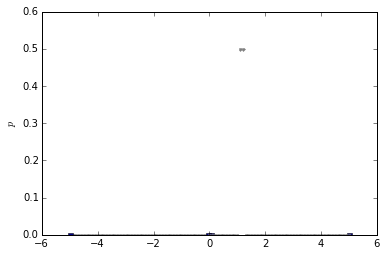

In [20]:
b = action.propogate_state(state_space.nearest((1.0,1)), dt=0.15)
ax = setup_belief_plot()
b.plot(ax);

In [21]:
b.metric_mean()

1.1499999999999999

In [22]:
action = GuardedVelocity(-1.0)
b = action.propogate_belief(b, dt=0.15)
ax = setup_belief_plot()
b.plot(ax);
b.metric_variance(), b.metric_mean()

NotImplementedError: 